# STM Transit Delay Feature Engineering and Data Preprocessing

This notebook preprocesses data about STM trip updates and weather data in order to build a tree-based regression model that predicts delays in seconds.

## Data Description

`trip_id` unique identifier of a trip<br>
`vehicle_id` unique identifier of a vehicle<br>
`occupancy_status` degree of passenger occupancy<br>
`route_id` bus or metro line<br>
`stop_id` stop number<br>
`stop_lat`stop latitude<br>
`stop_lon`stop longitude<br>
`stop_sequence` sequence of the stop, for ordering<br>
`trip_progress` how far along the trip is the bys from 0 to 1<br>
`wheelchair_boarding` indicates if the stop is accessible for people in wheelchair, 1 being true and 2 being false<br>
`realtime_arrival_time` actual arrival time, in milliseconds<br>
`scheduled_arrival_time` planned arrival time, in milliseconds<br>
`temperature` air temperature at 2 meters above ground, in Celsius<br>
`precipitation` total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters<br>
`windspeed` wind speed at 10 meters above ground, in km/h<br>
`weathercode` World Meteorological Organization (WMO) code<br>
`incident_nearby`indicates if an incident happened within 500 meters when the vehicle arrived at the stop

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder
import sys

In [2]:
# Import custom code
sys.path.insert(0, '..')
from scripts.custom_functions import INCIDENT_CATEGORIES, LOCAL_TIMEZONE, WEATHER_CODES

In [3]:
# Load data
df = pd.read_csv('../data/stm_weather_traffic_merged.csv')

## Feature Engineering

In [4]:
# Convert real and scheduled timestamps
df['realtime_arrival_time'] = pd.to_datetime(df['realtime_arrival_time'], origin='unix', unit='ms', utc=True)
df['scheduled_arrival_time'] = pd.to_datetime(df['scheduled_arrival_time'], origin='unix', unit='ms', utc=True)

In [5]:
# Calculate delay in seconds (real - scheduled)
df['delay'] = (df['realtime_arrival_time'] - df['scheduled_arrival_time']).dt.total_seconds()

## Small EDA

In [6]:
# Get correlations of features with delay
correlations = df.corr().iloc[:-1]['delay']
correlations.sort_values(key=abs, ascending=False)

stop_sequence             0.101779
trip_progress             0.078142
occupancy_status          0.056913
route_id                  0.025612
stop_lat                  0.022369
trip_id                  -0.020213
weathercode              -0.016340
stop_lon                  0.013915
scheduled_arrival_time   -0.011765
vehicle_id                0.011505
incident_nearby          -0.008754
windspeed                -0.005963
realtime_arrival_time    -0.005712
wheelchair_boarding       0.002732
temperature              -0.002603
stop_id                   0.002192
Name: delay, dtype: float64

In [7]:
# Get distribution of delays
df['delay'].describe()

count    56198.000000
mean        52.977828
std        229.348710
min      -8222.000000
25%          0.000000
50%          0.000000
75%         58.000000
max      19116.000000
Name: delay, dtype: float64

In [8]:
# Get proportion of trips that are on time
on_time_mask = df['delay'] == 0
print(f'{(on_time_mask.sum() / len(df)):.2%}')

64.69%


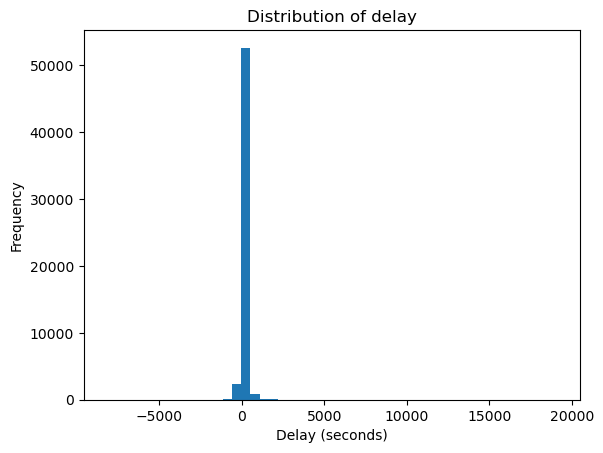

In [9]:
# Plot distribution of delay
plt.hist(df['delay'], bins=50)
plt.title('Distribution of delay')
plt.xlabel('Delay (seconds)')
plt.ylabel('Frequency')
plt.savefig('../images/delay_hist.png', bbox_inches='tight')
plt.show()

The plot shows there are some massive delays (~2h15min early to ~5h15min late), which could greatly affect the model performance.

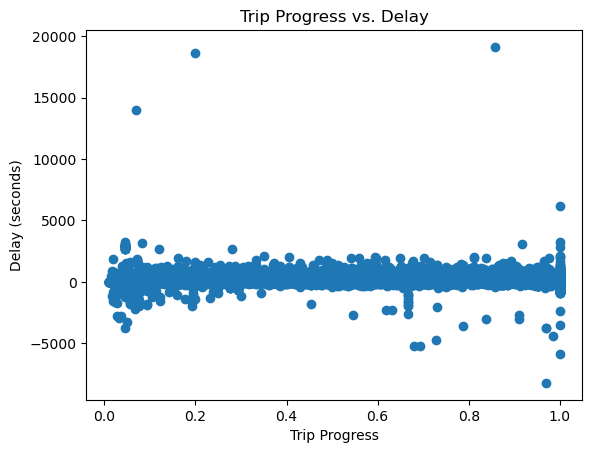

In [10]:
# Plot trip progress vs. delay
plt.scatter(x=df['trip_progress'], y=df['delay'])
plt.title('Trip Progress vs. Delay')
plt.xlabel('Trip Progress')
plt.ylabel('Delay (seconds)')
plt.savefig('../images/trip_progress_vs_delay.png', bbox_inches='tight')
plt.show()

From the plot, it looks like the delay is relatively stable across the trip progress. There are many data points that appear scattered around the x-axis, indicating that delays do not change significantly throughout the trip in many cases. The wide range of delays suggests that delays are highly variable, but there is not clear relationship between trip progress and delay. This could imply that other factors like traffic, accidents, mechanical issues or weather may have more impact on the delays.

## Data Preprocessing

### Handle Outliers

In [11]:
# Compute mean and standard deviation
mean_delay = df['delay'].mean()
std_delay = df['delay'].std()

In [12]:
# Filter outliers based on standard deviation
outlier_mask = (df['delay'] < mean_delay - 3 * std_delay) | (df['delay'] > mean_delay + 3 * std_delay)

In [13]:
# Get outliers
outliers = df[outlier_mask]

In [14]:
# Get proportion of outliers
print(f'{outlier_mask.mean():.2%}')

1.13%


In [15]:
# Remove outliers
df = df[~outlier_mask]

In [16]:
# Get new distribution
df['delay'].describe()

count    55561.000000
mean        45.750112
std        116.578535
min       -633.000000
25%          0.000000
50%          0.000000
75%         48.000000
max        740.000000
Name: delay, dtype: float64

The delay ranging from ~16 min early to 18min45sec seems more reasonable.

In [17]:
df.columns

Index(['trip_id', 'vehicle_id', 'occupancy_status', 'route_id', 'stop_id',
       'stop_lat', 'stop_lon', 'stop_sequence', 'trip_progress',
       'wheelchair_boarding', 'realtime_arrival_time',
       'scheduled_arrival_time', 'temperature', 'windspeed', 'weathercode',
       'incident_nearby', 'delay'],
      dtype='object')

### Encode Datetime

In [18]:
# Convert arrival times to local timezone
df['realtime_arrival_time'] = df['realtime_arrival_time'].dt.tz_convert(LOCAL_TIMEZONE)
df['scheduled_arrival_time'] = df['scheduled_arrival_time'].dt.tz_convert(LOCAL_TIMEZONE)

In [19]:
# Convert datetimes to day and hour
df['day'] = df['realtime_arrival_time'].dt.day_of_week
df['hour'] = df['realtime_arrival_time'].dt.hour

df['sch_day'] = df['scheduled_arrival_time'].dt.day_of_week
df['sch_hour'] = df['scheduled_arrival_time'].dt.hour

In [20]:
# Use Cyclical Encoding for day and hour, as it's more suitable for time-related features
# And the model can "understand" the wrap-around
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 7)

df['sch_day_sin'] = np.sin(2 * np.pi * df['sch_day'] / 7)
df['sch_day_cos'] = np.cos(2 * np.pi * df['sch_day'] / 7)

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['sch_hour_sin'] = np.sin(2 * np.pi * df['sch_hour'] / 24)
df['sch_hour_cos'] = np.cos(2 * np.pi * df['sch_hour'] / 24)

In [21]:
# Add boolean value is_weekend
weekend_mask = df['day'].isin([5, 6])
df['is_weekend'] = np.where(weekend_mask, 1, 0)

In [22]:
# Add boolean value is_peak_hour (weekdays from 7-9am or 4-6pm)
peak_hour_mask = (weekend_mask == False) & (df['hour'].isin([7, 8, 9, 16, 17, 18]))
df['is_peak_hour'] = np.where(peak_hour_mask, 1, 0)

### Use Label Encoding for vehicle_id, route_id and stop_id

In [23]:
le_vehicle = LabelEncoder()
df['vehicle_id'] = le_vehicle.fit_transform(df['vehicle_id'])

In [24]:
le_route = LabelEncoder()
df['route_id'] = le_route.fit_transform(df['route_id'])

In [25]:
le_stop = LabelEncoder()
df['stop_id'] = le_stop.fit_transform(df['stop_id'])

### Convert weathercode to Categories

In [26]:
# Create weather code mapping
weathercodes = df['weathercode'].sort_values().unique()
condition_list = []
label_list = []

for code in weathercodes:
  condition_list.append(df['weathercode'] == code)
  label_list.append(WEATHER_CODES[code])

In [27]:
# Create categories
df['weather'] = np.select(condition_list, label_list, default='Unknown')

In [28]:
df['weather'].value_counts()

weather
Clear sky       42311
Overcast        11471
Mainly clear     1779
Name: count, dtype: int64

In [29]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['weather'], drop_first=True, dtype='int64', prefix='weather')
df = df.join(one_hot)

### Convert incident_category to Categories 

## Export Data

In [31]:
assert df.isna().sum().sum() == 0

In [32]:
df.columns

Index(['trip_id', 'vehicle_id', 'occupancy_status', 'route_id', 'stop_id',
       'stop_lat', 'stop_lon', 'stop_sequence', 'trip_progress',
       'wheelchair_boarding', 'realtime_arrival_time',
       'scheduled_arrival_time', 'temperature', 'windspeed', 'weathercode',
       'incident_nearby', 'delay', 'day', 'hour', 'sch_day', 'sch_hour',
       'day_sin', 'day_cos', 'sch_day_sin', 'sch_day_cos', 'hour_sin',
       'hour_cos', 'sch_hour_sin', 'sch_hour_cos', 'is_weekend',
       'is_peak_hour', 'weather', 'weather_Mainly clear', 'weather_Overcast'],
      dtype='object')

In [33]:
# Keep encoded columns and reorder them
df = df[[
	'vehicle_id',
  	'occupancy_status',
  	'route_id', 
  	'stop_id',
  	'stop_lat',
  	'stop_lon',
	'stop_sequence',
  	'trip_progress',
	'wheelchair_boarding',
  	'day_sin',
  	'day_cos',
  	'sch_day_sin',
  	'sch_day_cos',
  	'hour_sin',
  	'hour_cos', 
	'sch_hour_sin',
  	'sch_hour_cos',
  	'is_weekend',
  	'is_peak_hour', 
	'temperature', 
	#'precipitation', 
	'windspeed', 
  	#'weather_Drizzle',
	'weather_Mainly clear', 
  	'weather_Overcast',
  	#'weather_Partly cloudy',
    #'weather_Slight rain',
    'incident_nearby',
    #'nearest_incident_distance',
  	#'incident_delay',
	#'incident_delay_magnitude',
	#'incident_RoadClosed',
  	#'incident_RoadWorks',
  	'delay'
]]

In [34]:
# Export encoders
encoders = {
	'le_vehicle': le_vehicle,
  	'le_route': le_route,
  	'le_stop': le_stop,
}

with open('../models/label_encoders.pickle', 'wb') as handle:
	pickle.dump(encoders, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55561 entries, 0 to 56197
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vehicle_id            55561 non-null  int64  
 1   occupancy_status      55561 non-null  int64  
 2   route_id              55561 non-null  int64  
 3   stop_id               55561 non-null  int64  
 4   stop_lat              55561 non-null  float64
 5   stop_lon              55561 non-null  float64
 6   stop_sequence         55561 non-null  int64  
 7   trip_progress         55561 non-null  float64
 8   wheelchair_boarding   55561 non-null  int64  
 9   day_sin               55561 non-null  float64
 10  day_cos               55561 non-null  float64
 11  sch_day_sin           55561 non-null  float64
 12  sch_day_cos           55561 non-null  float64
 13  hour_sin              55561 non-null  float64
 14  hour_cos              55561 non-null  float64
 15  sch_hour_sin          55

In [36]:
# Export dataframe
df.to_csv('../data/preprocessed.csv', index=False)

## End